# Random Forest for supervisioned land cover classification

Let's start by importing the necessary packages

In [1]:
import descarteslabs as dl
import matplotlib.pyplot as plt
import numpy as np
from osgeo import osr
import pandas as pd
from pyproj import Proj, transform
from sklearn.ensemble import RandomForestClassifier

Defining the region to be studied

In [2]:
shape_TL = {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -51.837615966796875,
              -20.87421043965721
            ],
            [
              -51.61376953124999,
              -20.87421043965721
            ],
            [
              -51.61376953124999,
              -20.698957924554925
            ],
            [
              -51.837615966796875,
              -20.698957924554925
            ],
            [
              -51.837615966796875,
              -20.87421043965721
            ]
          ]
        ]
      }
    }

Using the DescartesLabs API to search the Landsat scenes for the region in august 2018.

2


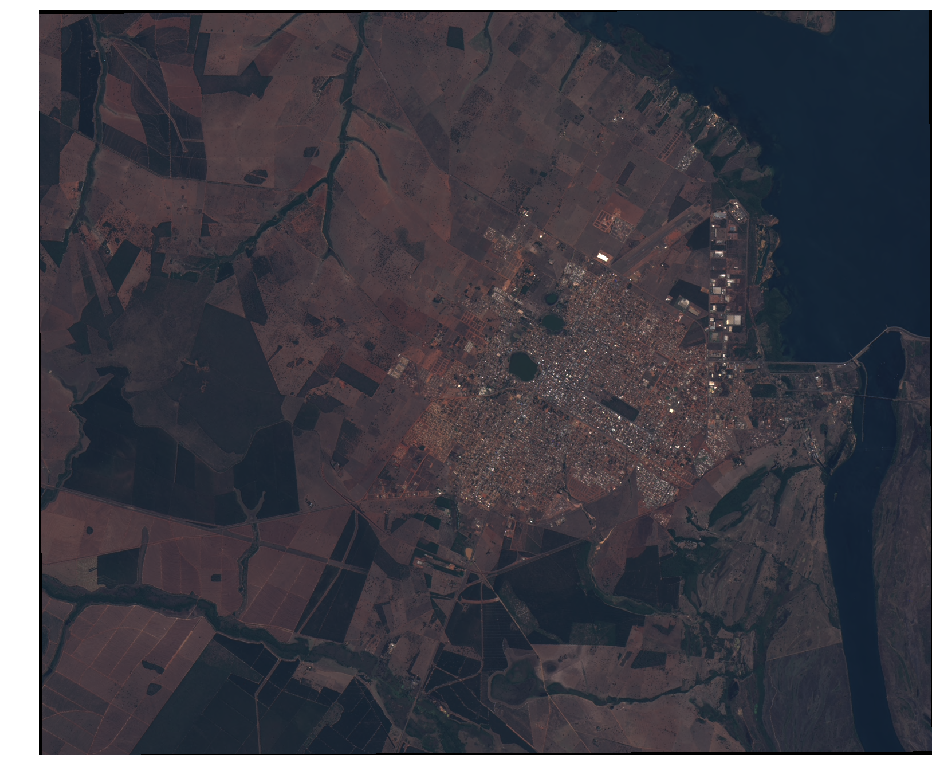

In [3]:
feature_collection = dl.metadata.search(products='landsat:LC08:01:RT:TOAR', start_time='2018-08-01', end_time='2018-08-31', cloud_fraction=0.1, limit=10, geom=shape_TL['geometry'])
print (len(feature_collection['features']))

ids = [f['id'] for f in feature_collection['features']]
arrTL, metaTL = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue','coastal-aerosol','nir','swir1','swir2','tirs1'],
    scales=[[0,4000,0,255], [0,4000,0,255], [0,4000,0,255], [0,10000,0,255], [0,10000,0,255], [0,10000,0,255], [0,10000,0,255], [0,16383,0,255]],
    data_type='Byte',
    resolution=15,
    cutline=shape_TL['geometry'],
)
plt.figure(figsize=[16,16])
plt.axis('off')
plt.imshow(arrTL[:,:,0:3])

Getting projection and geotransform of metadata

In [4]:
proj = metaTL['coordinateSystem']['wkt']
geo_transform = metaTL['geoTransform']

Import csv with coordinates collected at points where the class is known

In [10]:
coordenadas  = pd.DataFrame(pd.read_csv('coordenadas.csv'))
coordenadas['classe'].value_counts()
coordenadas = coordenadas.assign(col="",row="")

Transform coordinates in format epsg4326 to columns and rows

In [11]:
p2 = osr.SpatialReference()
p2.ImportFromWkt(proj)
new_proj = p2.ExportToProj4()   
inProj = Proj(init='epsg:4326')
outProj = Proj(new_proj)
xOrigin = geo_transform[0]
yOrigin = geo_transform[3]
pixelWidth = geo_transform[1]
pixelHeight = -geo_transform[5]
for i,r in coordenadas.iterrows():
   point = transform(inProj,outProj,coordenadas['longitude'].iloc[i],coordenadas['latitude'].iloc[i])
   col = int((point[0] - xOrigin) / pixelWidth)
   row = int((yOrigin - point[1]) / pixelHeight) 
   coordenadas['col'].iloc[i] = col
   coordenadas['row'].iloc[i] = row


C:\Users\Joao\Anaconda3\envs\PythonGeo\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Plot the image of region with the poins colected

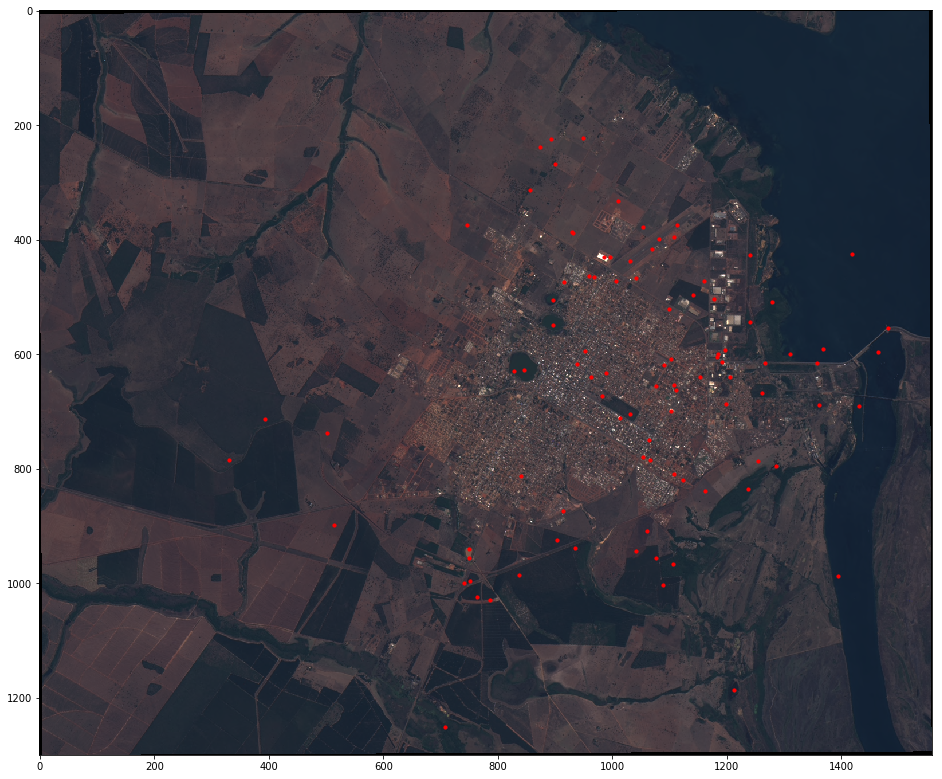

In [12]:
plt.figure(figsize=[16,16])
plt.imshow(arrTL[:,:,0:3])
plt.scatter(coordenadas['col'],coordenadas['row'],s=10,marker="o",color='Red')


In [ ]:
groups = { 0 : "Àgua", 1 : "Floresta", 2 : "Vegetação rasteira", 3 : "Construção", 4 : "Terra"}
coordenadas['classificação'] = coordenadas['classe'].map(groups)

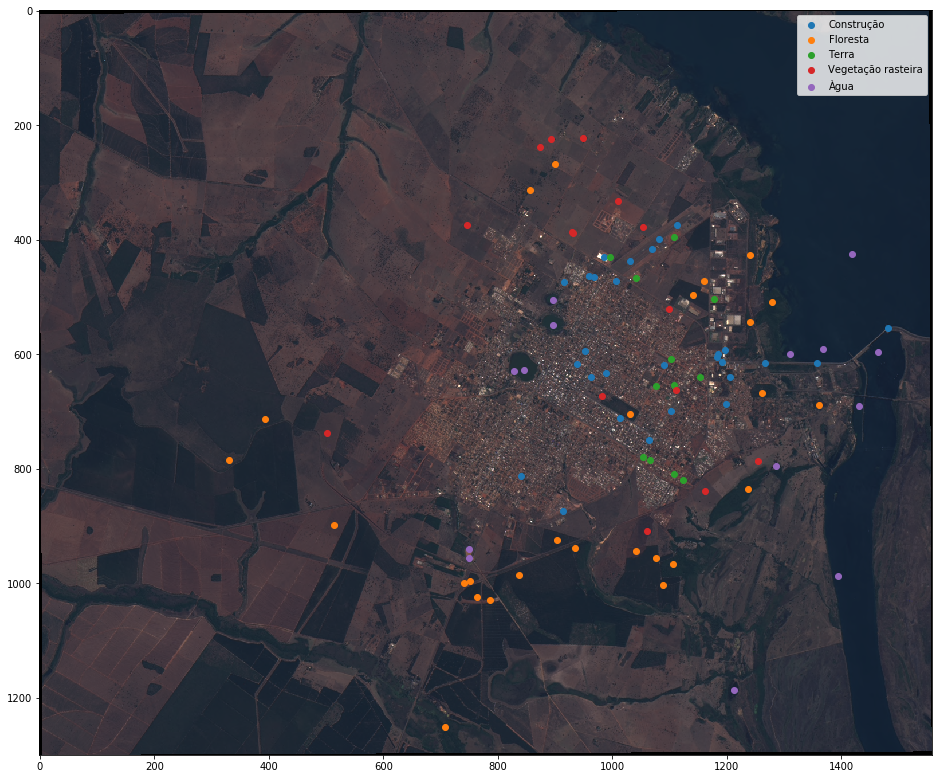

In [13]:
fig, ax = plt.subplots(figsize=(16,16))
for c, df in coordenadas.groupby('classificação'):
    ax.scatter(df['col'], df['row'], label=c)
ax.imshow(arrTL[:,:,0:3])
ax.legend()

In [14]:
X = []
for i,r in coordenadas.iterrows():
    X += [list(arrTL[coordenadas['row'].iloc[i],coordenadas['col'].iloc[i],:])]
X = np.array(X) 
Y = np.array(coordenadas['classe'])
r,c,b = arrTL.shape
X_test = arrTL.reshape(r*c,b)

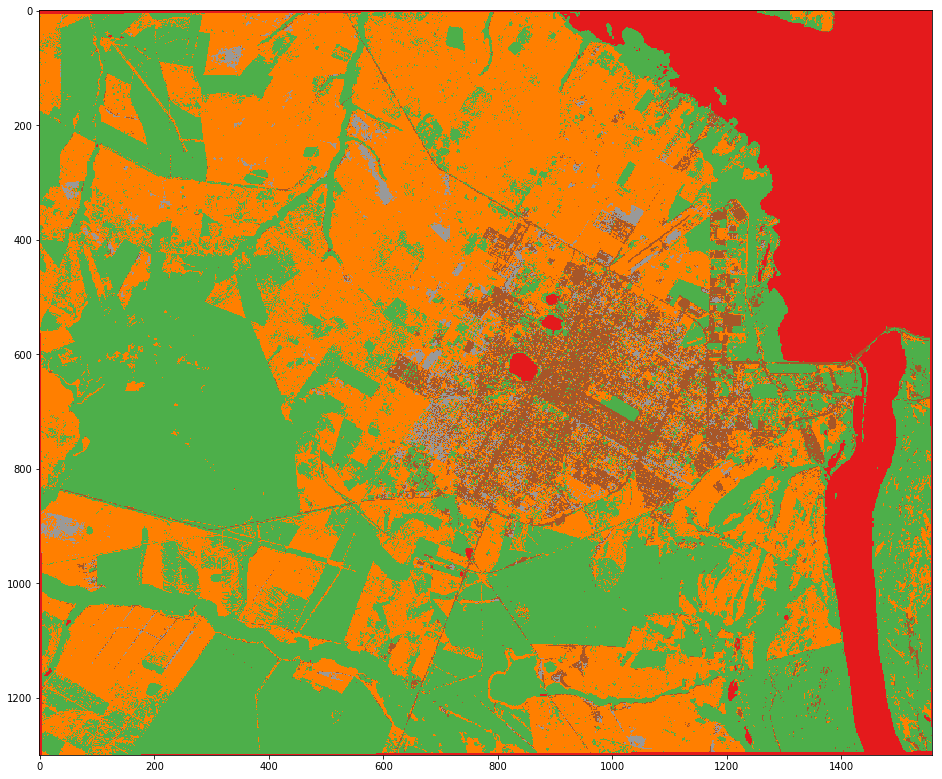

In [15]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X,Y)
y_pred=clf.predict(X_test)
img_clf = y_pred.reshape(r,c)

plt.figure(figsize=[16,16])
plt.imshow(img_clf, vmin=0, vmax=4, cmap = 'Set1')

In [16]:
area_agua = img_clf[img_clf == 0].shape[0]*pixelWidth*pixelHeight/1000000
area_flores = img_clf[img_clf == 1].shape[0]*pixelWidth*pixelHeight/1000000
area_vegrast = img_clf[img_clf == 2].shape[0]*pixelWidth*pixelHeight/1000000
area_constr = img_clf[img_clf == 3].shape[0]*pixelWidth*pixelHeight/1000000
area_terra = img_clf[img_clf == 4].shape[0]*pixelWidth*pixelHeight/1000000
area_tot = c*r*pixelWidth*pixelHeight/1000000

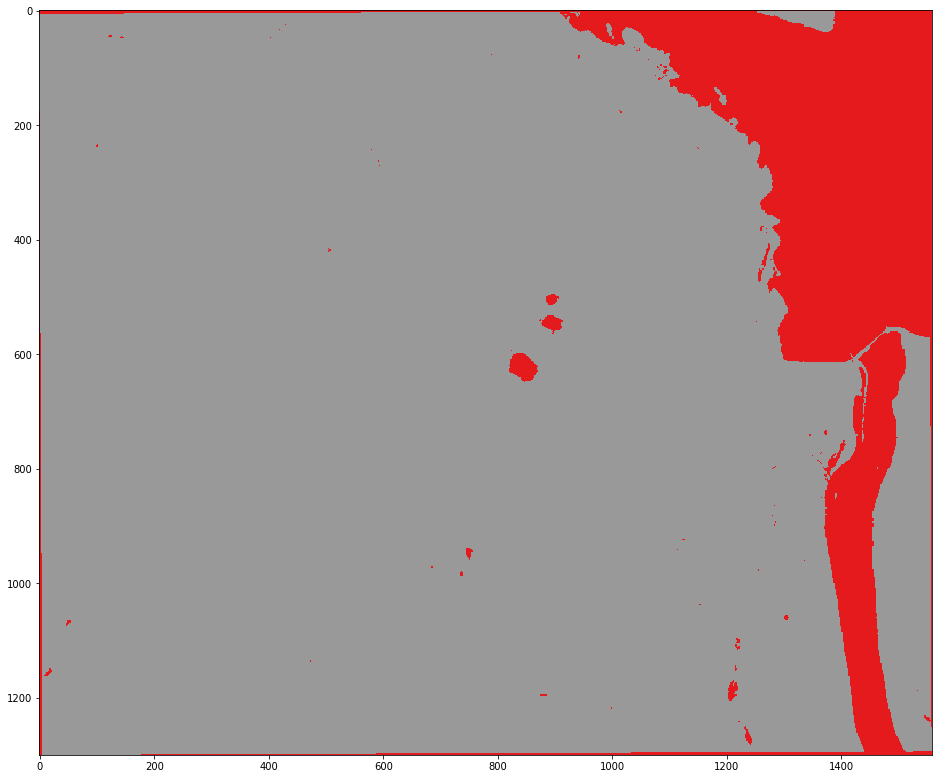

In [17]:
mask_agua = np.zeros((r,c))
mask_agua[img_clf != 0] = 1
plt.figure(figsize=[16,16])
plt.imshow(mask_agua, vmin=0, vmax=1, cmap = 'Set1')